# Matching cohorts
This is the notebook for matching the control subjects with our ET subjects to creat new subsamples that is 
## Data: 
    - 1. Freesurfer results: ICV. Lh/Rh_cerebellum_gm/wm (generated by "collect_volumes.sh" script);
        - Left/ Right cerebellum gray/white matter volumes 
    - 2. Cerebellar SUIT segmentation with SUIT and MDTB atlas; 
         - SUIT: Vermis VI, Vermis_CrusI,  Vermis_CrusII, CrusI, CrusII, Dentate nucleus;
         - MBTB: MDTB functional regions 1,2,4,5;
    - 3. Cerebellar MAGeTBrain [MAGeTBrain pipeline](https://github.com/CobraLab/documentation/wiki/MAGeTBrain#collecting-volumes)
        - MAGeT: Vermis VI, Vermis_CrusI,  Vermis_CrusII, CrusI, CrusII, Dentate nucleus;

## Cohorts
- Current cohort: MNI ET/NC (38/32, PPMI NC (116) and ADNI NC(308), QC information needed.

## Tasks
- Compare total cerebellar volumes (left and right)
- Compare lobule volumes (13 per hemisphere)

## Covariates
- Age, Sex, site, eTIV

In [2]:
## read tabular data of demographics and re-format for latter analysis
from pathlib import Path
import nipype.interfaces.io as nio
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# read tabular data
data_dir = Path("/codes/tab_data")
data_all_file = data_dir/'all_Des-cere_preped_qcInfo.csv'
matched_data_file = data_dir/'matched_Des-cere_qced.csv'
data_df = pd.read_csv(data_all_file , sep=',', header=0, index_col=0);

# prepare Cerebellar lobules lists
SUIT_labels = ['Left_I_IV','Right_I_IV','Left_V','Right_V','Left_VI','Vermis_VI','Right_VI','Left_CrusI','Vermis_CrusI','Right_CrusI','Left_CrusII','Vermis_CrusII','Right_CrusII','Left_VIIb','Vermis_VIIb','Right_VIIb','Left_VIIIa','Vermis_VIIIa','Right_VIIIa','Left_VIIIb','Vermis_VIIIb','Right_VIIIb','Left_IX','Vermis_IX','Right_IX','Left_X','Vermis_X','Right_X','Left_Dentate','Right_Dentate','Left_Interposed','Right_Interposed','Left_Fastigial','Right_Fastigial'];
SUIT_labels = [ x.replace('-','_') for x in SUIT_labels]
SUIT_l_labels = ['Left_I_IV',  'Left_V', 'Left_VI', 'Left_CrusI', 'Left_CrusII', 'Left_VIIb', 'Left_VIIIa', 'Left_VIIIb', 'Left_IX', 'Left_X', 'Left_Dentate', 'Left_Interposed', 'Left_Fastigial'];
SUIT_r_labels = ['Right_I_IV','Right_V','Right_VI','Right_CrusI','Right_CrusII','Right_VIIb','Right_VIIIa','Right_VIIIb','Right_IX','Right_X','Right_Dentate','Right_Interposed','Right_Fastigial'];
SUIT_v_labels = ['Vermis_VI', 'Vermis_CrusI', 'Vermis_CrusII', 'Vermis_VIIb', 'Vermis_VIIIa','Vermis_VIIIb', 'Vermis_IX', 'Vermis_X'];
MDTB_labels   = ['MDTB_'+str(x+1) for x in range(10)];
# QC val list
qc_list = ['freesurfer_score', 'suit_score', 'maget_score']

# Create new colums (simple calculation)
curr_df = data_df.copy()
curr_df.loc[:,'Cerebellum_White_Matter']=curr_df['Left_Cerebellum_White_Matter']+curr_df['Right_Cerebellum_White_Matter'];
curr_df.loc[:,'Cerebellum_Cortex']=curr_df['Left_Cerebellum_Cortex']+curr_df['Right_Cerebellum_Cortex'];
curr_df.loc[:,'cerebellumVol']=curr_df['Cerebellum_Cortex']+curr_df['Cerebellum_White_Matter']
# calculate the Infra tentorium volumen approximately by eTIV-SupraTentorialVol
curr_df.loc[:,'InfraTentorialVol']=curr_df['eTIV']-curr_df['SupraTentorialVol']

# Create cohort (dataset MNI/PPMI/ADNI) and group (ET/NC)
curr_df.loc[:,'cohort']=curr_df.loc[:,'group'].copy()
curr_df.loc[:,'cohort'] = ['MNI' if x=='ET' or x=='NC' else x for x in curr_df.loc[:,'cohort']]
curr_df.loc[:,'group']  = [x if x=='ET' else 'NC' for x in curr_df['group']]

## covariates and target labels
demo_list=['age','sex','group', 'cohort','site','eTIV','SupraTentorialVol', 'SupraTentorialVolNotVent','InfraTentorialVol']
cerebellum_list = ['Left_Cerebellum_Cortex','Left_Cerebellum_White_Matter',
                   'Right_Cerebellum_Cortex','Right_Cerebellum_White_Matter',
                   'Cerebellum_Cortex','Cerebellum_White_Matter'];
lobular_list = ['Vermis_VI', 'Vermis_CrusI', 'Vermis_CrusII', 
                'Left_CrusI', 'Right_CrusI', 'Left_CrusII', 'Right_CrusII','Left_Dentate', 'Right_Dentate',
                'MDTB_1', 'MDTB_2', 'MDTB_4', 'MDTB_5'];

#multiple comparison correction columne
df_n_comp=pd.DataFrame(zip(cerebellum_list+lobular_list, [4,4,4,4,2,2, 9,9,9,9,9,9,9,9,9, 4,4,4,4]), 
                       index=cerebellum_list+lobular_list, columns=['ROI','n_comp'])

# Applying QC: 1. ET: 38 -> 34; 2. NC: 32 -> 29; 3. ADNI: 309 -> 223; 4. PPMI: 116 -> 78;
qc_th=2
df_all_qc=curr_df[(curr_df['freesurfer_score']>=qc_th)&(curr_df['suit_score']>=qc_th)&(curr_df['maget_score']>=qc_th)]

# Select the data
tar_list = demo_list
match_df = df_all_qc[demo_list].copy()

In [3]:
### statistical evaluation for group age and sex differences
from utils_et_biomarker.utils import age_sex_comp_test
mni_et_df  = match_df[(match_df['cohort']=='MNI')&(match_df['group']=='ET')].copy()
mni_nc_df  = match_df[(match_df['cohort']=='MNI')&(match_df['group']=='NC')].copy()
ppmi_nc_df = match_df[(match_df['cohort']=='PPMI')&(match_df['group']=='NC')].copy()
adni_nc_Df = match_df[(match_df['cohort']=='ADNI')&(match_df['group']=='NC')].copy()
all_nc_df  = match_df[(match_df['group']=='NC')].copy()
other_nc_df = match_df[(match_df['cohort']!='MNI')&(match_df['group']=='NC')].copy()

# Bebore matching
print("Before matching, test sex and age distribution for ET/NC of MNI:")
age_sex_comp_test(mni_et_df, mni_nc_df)
print("Before matching, test sex and age distribution for ET/NC of PPMI:")
age_sex_comp_test(mni_et_df, ppmi_nc_df)
print("Before matching, test sex and age distribution for ET/NC of ADNI:")
age_sex_comp_test(mni_et_df, adni_nc_Df)


Before matching, test sex and age distribution for ET/NC of MNI:
ET / NC  :
M/F:  26 / 8 ;  18 / 11
age mean:  73.73529411764706 / 55.03448275862069
age std:  7.254293706736771 / 10.857791009950576
Sex Chisqure test: 
 chisq =0.933215, pvalue = 0.334029
Age 2-sided independent t-test (tstat, pval, df): 
 tstat =8.141088, pvalue = 0.000000, df = 61 


Before matching, test sex and age distribution for ET/NC of PPMI:
ET / NC  :
M/F:  26 / 8 ;  47 / 31
age mean:  73.73529411764706 / 60.67948717948718
age std:  7.254293706736771 / 11.420525597729945
Sex Chisqure test: 
 chisq =2.074915, pvalue = 0.149738
Age 2-sided independent t-test (tstat, pval, df): 
 tstat =6.139209, pvalue = 0.000000, df = 110 


Before matching, test sex and age distribution for ET/NC of ADNI:
ET / NC  :
M/F:  26 / 8 ;  108 / 115
age mean:  73.73529411764706 / 76.62780269058295
age std:  7.254293706736771 / 10.077650685962528
Sex Chisqure test: 
 chisq =8.205650, pvalue = 0.004176
Age 2-sided independent t-test (tst

{'sex': [8.205650388819329, 0.004176013725434352],
 'age': [-1.6099832592336414, 0.10863869098350716, 255.0]}

# matching stategy:
1. Based on L2 distance
2. Based on propensity score
3. Lacking the Maximum Mean Discrepancy (distance distribution) based methods

https://link.springer.com/chapter/10.1007/978-3-319-58347-1_5

https://journals.lww.com/epidem/Abstract/2017/05000/Matching_Weights_to_Simultaneously_Compare_Three.13.aspx

https://stats.stackexchange.com/questions/276497/maximum-mean-discrepancy-distance-distribution


https://www.youtube.com/watch?v=fFrhvrGg9hw

https://arxiv.org/abs/2010.11415

https://arxiv.org/pdf/1906.05944.pdf


In [26]:
# recalculate the power and number of subjects needed
from statsmodels.stats import power
import math
from numpy import array
import matplotlib.pyplot as plt
from statsmodels.stats.power import TTestIndPower

# Before QC: n_et=38; n_nc=32;
n_et=len(match_df[(match_df['cohort']=='MNI')&(match_df['group']=='ET')])
n_nc=len(match_df[(match_df['cohort']=='MNI')&(match_df['group']=='NC')])

effect_size_expected=0.6; alpha_expected=0.05; power_expected=0.9;

# borrow controls from PPMI to achieve better power and median of literature effect size
print('1. Number of Controls needed (in total) for 1-sided test, at alpha='+str(alpha_expected)+', power='+str(power_expected)+' and effect size='+str(effect_size_expected)+': ')
r_1sided_expected=power.tt_ind_solve_power(effect_size=effect_size_expected, nobs1=n_et, alpha=alpha_expected, power=power_expected, ratio=None, alternative='larger')
n_nc_1sided_needed = math.ceil(r_1sided_expected*n_et)
print(' Total nc needed: ',  n_nc_1sided_needed, ', r=', r_1sided_expected)

print('2. Number of Controls needed (in total) for 2-sided tests, for alpha='+str(alpha_expected)+', power='+str(power_expected)+' and effect size='+str(effect_size_expected)+': ')
r_2sided_expected=power.tt_ind_solve_power(effect_size=effect_size_expected, nobs1=n_et, alpha=alpha_expected, power=power_expected, ratio=None, alternative='two-sided')
n_nc_2sided_needed = math.ceil(r_2sided_expected*n_et)
print('Total nc needed: ',  n_nc_2sided_needed, ', r=', r_2sided_expected)

1. Number of Controls needed (in total) for 1-sided test, at alpha=0.05, power=0.9 and effect size=0.6: 
 Total nc needed:  83 , r= 2.4251275582825733
2. Number of Controls needed (in total) for 2-sided tests, for alpha=0.05, power=0.9 and effect size=0.6: 
Total nc needed:  219 , r= 6.412658861429534


In [30]:
# matching by L2 distance
import math
from utils_et_biomarker.utils import age_sex_comp_test, dist_score_L2
# originally: nc_needed=116;
nc_needed=max(n_nc_1sided_needed, n_nc_2sided_needed)

def distr_match(distr_target, n_target, distr_source, match_method, para):
    #inlcuding all the subjects within the percentile of target distribution,
    import pandas as pd
    # parameters parsing
    percent_th = para['percentile']; percent_th_c = 100-para['percentile']; 
    ## calculating the expected number of matched subjects 
    distr_source.loc[:,'sub_id']=distr_source.index;
    res=distr_source;
    distr_target_m = distr_target[distr_target['sex']=='M'].copy(); 
    distr_target_f=distr_target[distr_target['sex']=='F'].copy();
    distr_source_m = distr_source[distr_source['sex']=='M'].copy(); 
    distr_source_f=distr_source[distr_source['sex']=='F'].copy();
    n_target_m = round(nc_needed*len(distr_target_m)/(len(distr_target)));  n_target_f = nc_needed-n_target_m;
    target_m_mean = distr_target_m['age'].mean(); target_m_std = distr_target_m['age'].std();
    target_f_mean = distr_target_f['age'].mean(); target_f_std = distr_target_f['age'].std(); 
    print('Expecting ',n_target_m,' M and ',n_target_f,'F')
    
    ## differenct methods
    if match_method=='l2_dist':
        age_tar_m=distr_target_m['age'];  age_tar_f=distr_target_f['age'];
        distr_source_m.loc[:,'L2_score'] = distr_source_m['age'].map(lambda x: dist_score_L2(x, age_tar_m));
        distr_source_f.loc[:,'L2_score'] = distr_source_f['age'].map(lambda x: dist_score_L2(x, age_tar_f));
        # thresholding part removed by now
        #th_m_cut_h = np.percentile(distr_source_m['L2_score'], percent_th_c); 
        #th_m_cut_l = np.percentile(distr_source_m['L2_score'], percent_th); 
        #th_f_cut_h = np.percentile(distr_source_f['L2_score'], percent_th_c);
        #th_f_cut_l = np.percentile(distr_source_f['L2_score'], percent_th);
        #res_m_sel=distr_source_m[(distr_source_m['L2_score']>th_m_cut_l)&(distr_source_m['L2_score']<th_m_cut_h)].copy(); 
        #res_f_sel=distr_source_f[(distr_source_f['L2_score']>th_f_cut_l)&(distr_source_f['L2_score']<th_f_cut_h)].copy();
        res_m_sel=distr_source_m.copy()
        res_f_sel=distr_source_f.copy()
        res_sel = pd.concat([res_m_sel, res_f_sel])
        n_matched_m = len(res_m_sel); n_matched_f = len(res_f_sel);
        print('L2 matching get ', len(res_sel), ' matched M: ', len(res_m_sel),'F: ', len(res_f_sel))
        
        # if we our matched subjects lies 5%-95% NC 
        if n_target_m <= n_matched_m:
            res_m_sel1 = res_m_sel.sample(n=n_target_m, random_state=1);
            if n_target_f <= n_matched_f:
                res_f_sel1 = res_f_sel.sample(n=n_target_f, random_state=1);
                res_sel = pd.concat([res_m_sel1, res_f_sel1], ignore_index=True)
                print('Get matched M/F: ', len(res_m_sel1), '/', len(res_f_sel1) )
                return res_sel
            else:
                n_more = n_target_f-n_matched_f;
                res_f_sel1 = res_f_sel.sample(n=n_target_f, random_state=1).copy();
                res_sel = pd.concat([res_m_sel1, res_f_sel1], ignore_index=True)
                print('Get matched M, need resample more F: ', len(res_m_sel2), '/', len(res_f_sel) )
                print(n_more, ' F resampled.')
                return res_sel
        else:
            n_more_m = n_target_m-n_matched_m;
            print(n_more_m, ' M resampled.')
            res_m_sel1 = res_m_sel.sample(n=n_target_m, random_state=1);
            if n_target_f <= n_matched_f:
                res_f_sel1 = res_f_sel.sample(n=n_target_f, random_state=1);
                res_sel = pd.concat([res_m_sel1, res_f_sel1], ignore_index=True)
                print('Need resample M, Get matched F: ', len(res_m_sel1), '/', len(res_f_sel1) )
                return res_sel
            else:
                n_more_f = n_target_f-n_matched_f;
                print(n_more_f, ' F resampled.')
                res_f_sel1 = res_f_sel.sample(n=n_target_f, random_state=1);
                res_sel = pd.concat([res_m_sel1, res_f_sel1], ignore_index=True)
                print('Fail to get enough matched subjects!')
                print('Need to resample M/F: ', len(res_m_sel), '/', len(res_f_sel) )
                
                return res_sel
    elif match_method=='psm':
        pass
    else:
        print(match_method, ' is not supported yet!!!')
    return res
####

## use
para={'percentile':5}
#match
l2_matched=distr_match(mni_et_df, nc_needed, all_nc_df, 'l2_dist', para)
# test
age_sex_comp_test(mni_et_df, l2_matched)
#percentile_matched

Expecting  167  M and  52 F
L2 matching get  330  matched M:  173 F:  157
Get matched M/F:  167 / 52
ET / NC  :
M/F:  26 / 8 ;  167 / 52
age mean:  73.73529411764706 / 71.15525114155251
age std:  7.254293706736771 / 13.236161452832384
Sex Chisqure test: 
 chisq =0.035827, pvalue = 0.849873
Age 2-sided independent t-test (tstat, pval, df): 
 tstat =1.109734, pvalue = 0.268176, df = 251 




{'sex': [0.035827250968052324, 0.8498726811714004],
 'age': [1.1097342633587033, 0.26817560844334454, 251.0]}

Text(0.5, 0.98, 'Matched Normal Controls with L2 distance')

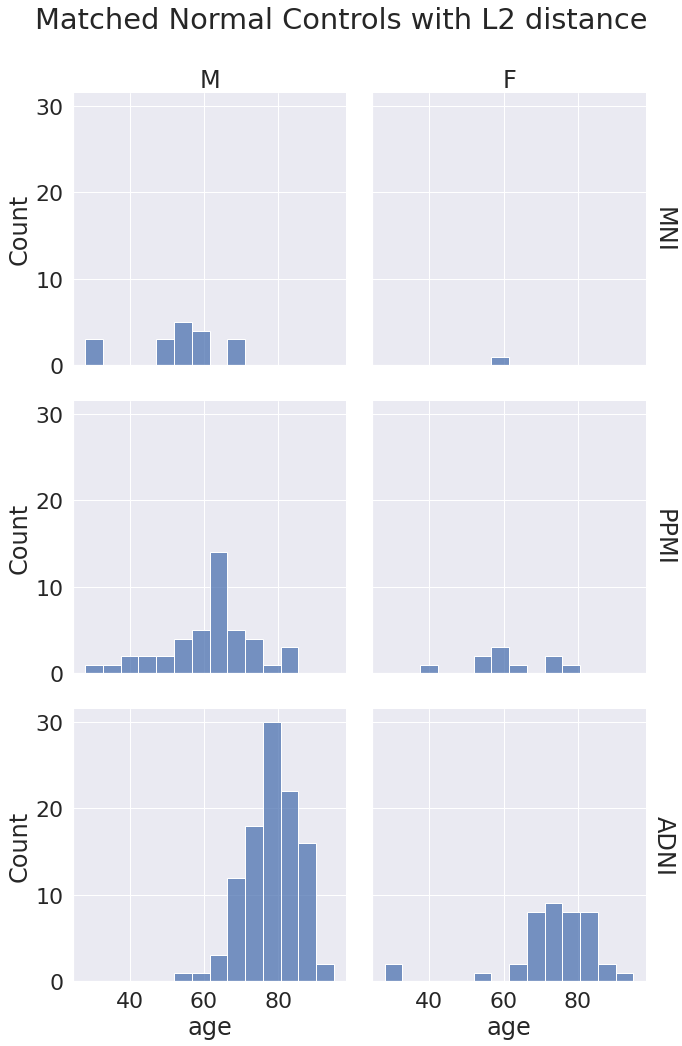

In [31]:
# plot the matched NC cohorts
#vis_df=pd.concat([mni_et_df,l2_matched])
vis_df=l2_matched.copy()
SEX_ORDER=['M', 'F']; COHORT_ORDER=['MNI','PPMI','ADNI']
sns.set_theme(style="darkgrid")
sns.set(font_scale=2)
dist_plt=sns.displot(vis_df, x="age", row="cohort", col='sex',
                     facet_kws=dict(margin_titles=True),
                     col_order=SEX_ORDER, row_order=COHORT_ORDER)
dist_plt.set_titles(col_template="{col_name}", row_template="{row_name}")
dist_plt.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
dist_plt.fig.suptitle('Matched Normal Controls with L2 distance')
#display the L2 scores
#dist_plt=sns.displot(vis_df, x="L2_score", row="cohort", col='sex',
#                     facet_kws=dict(margin_titles=True),
#                     col_order=SEX_ORDER, row_order=COHORT_ORDER)
#dist_plt.set_titles(col_template="{col_name}", row_template="{row_name}")

In [32]:
matched_df=df_all_qc.loc[l2_matched.sub_id,:].copy()
matched_df=pd.concat([matched_df, df_all_qc[df_all_qc['group']=='ET'].copy()]).copy()
display(matched_df)
matched_df.to_csv(matched_data_file)

,age,sex,Left_Lateral_Ventricle,Left_Inf_Lat_Vent,Left_Cerebellum_White_Matter,Left_Cerebellum_Cortex,Left_Thalamus_Proper,Left_Caudate,Left_Putamen,Left_Pallidum,...,is_Male,is_Female,freesurfer_score,suit_score,maget_score,Cerebellum_White_Matter,Cerebellum_Cortex,cerebellumVol,InfraTentorialVol,cohort
sub_100S4511,70,M,11427.6,424.4,15911.9,55331.8,6600.8,3211.9,4552.5,1936.0,...,NaN,NaN,2,3,2,31457.0,109479.2,140936.2,587664.415344,ADNI
sub_130S4343,83,M,10845.4,548.5,13456.3,45573.4,5896.1,3676.7,4221.8,1646.3,...,NaN,NaN,3,3,3,27066.9,92216.6,119283.5,592246.225723,ADNI
sub_002S4225,70,M,23852.7,796.2,16486.6,54874.6,7387.1,3784.2,5214.4,2255.1,...,NaN,NaN,3,2,3,31937.6,110458.2,142395.8,748281.968552,ADNI
sub_041S4083,85,M,31389.4,961.4,14308.6,57239.2,6839.4,3815.4,3906.0,1537.7,...,NaN,NaN,2,2,3,28797.1,117169.7,145966.8,713409.711153,ADNI
sub_032S4429,79,M,24074.8,652.9,10650.4,44728.0,6142.3,4306.2,5317.6,2188.5,...,NaN,NaN,2,3,3,21895.7,90226.2,112121.9,605365.562410,ADNI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sub_5700,65,M,9312.9,666.8,13890.8,52756.7,7177.5,3617.3,4982.0,1992.5,...,1.0,0.0,3,2,3,27363.6,107057.3,134420.9,531060.495850,MNI
sub_7000,60,M,8617.5,478.7,15254.4,54279.0,6604.6,3851.4,4711.3,1916.3,...,1.0,0.0,3,3,3,29375.1,110385.3,139760.4,542491.804010,MNI
sub_7400,73,F,10308.7,271.7,12815.0,45502.6,6363.5,2973.3,4053.1,1876.1,...,0.0,1.0,3,3,3,24583.4,92513.7,117097.1,546616.108254,MNI
sub_7800,61,M,6326.8,544.9,13014.1,50390.7,5420.6,2944.2,3799.8,1578.5,...,1.0,0.0,3,3,3,25626.6,100291.5,125918.1,436383.428566,MNI
